In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from matplotlib import style
import warnings 

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree

warnings.filterwarnings('ignore')
style.use('ggplot')

In [66]:
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
print(data.shape)
data.head(10)

(6015158, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0.0,0.0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0.0,0.0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0.0,0.0


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6015158 entries, 0 to 6015157
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         float64
 10  isFlaggedFraud  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 504.8+ MB


# **Exploratory Data Analysis (EDA)**

step              0
type              0
amount            1
nameOrig          1
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


<Axes: >

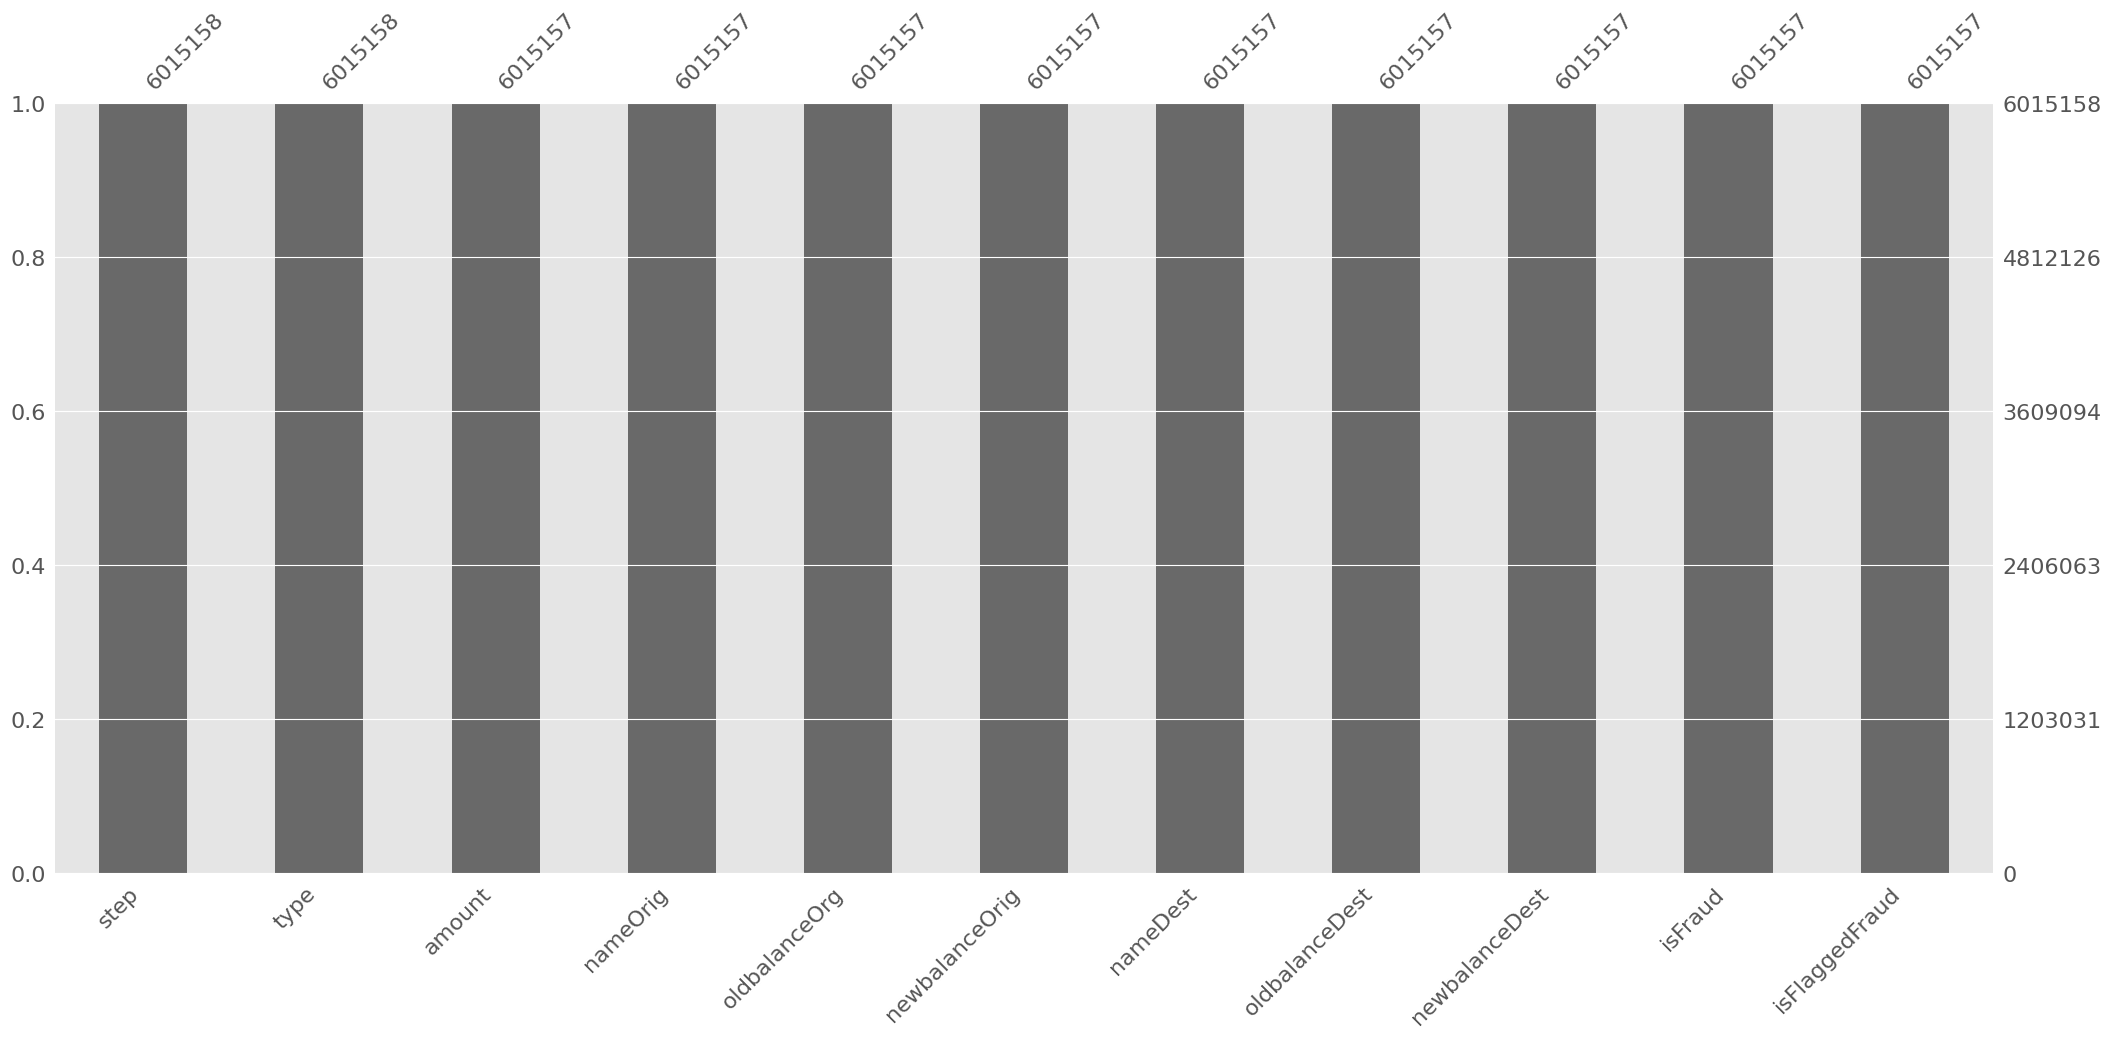

In [68]:
# Check Missing Value
print(data.isnull().sum())
# Visualize
msno.bar(data)

In [69]:
# Check for Duplicates
data.duplicated().sum()

np.int64(0)

In [70]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [71]:
# Insights on nameDest Feature that starts with Letter M
m_customers = data[data['nameDest'].str.startswith('M') == True]
print(m_customers.shape)
m_customers.head()

(2029990, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0.0,0.0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0.0,0.0


In [72]:
# M-customers by Fraud
m_customer_by_fraud = m_customers.groupby('type')['isFraud'].sum()
m_customer_by_fraud

type
PAYMENT    0.0
Name: isFraud, dtype: float64

> Unfortunately, there's not much information on the m_customers in regards to our model, I'll go ahead and filter them out

In [74]:
# Filter out the m-customers
not_m_customers = data[data['nameDest'].str.startswith('M') == False]
print(not_m_customers.shape)
not_m_customers.head()

(3985167, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.00,1.0,0.0
9,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0.0,0.0
10,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0.0,0.0
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.00,C476402209,5083.0,51513.44,0.0,0.0


In [75]:
not_m_customers.describe().round(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,3985167.00,3985167.00,3985167.00,3985167.00,3.985167e+06,3.985167e+06,3985167.00,3985167.0
mean,223.71,265418.00,1238959.60,1275126.68,1.655033e+06,1.845394e+06,0.00,0.0
std,119.17,736283.57,3530446.34,3571537.38,4.009997e+06,4.348541e+06,0.04,0.0
min,1.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00,0.00,0.0
25%,142.00,76171.67,0.00,0.00,1.413239e+05,2.236206e+05,0.00,0.0
50%,232.00,159121.95,17280.00,0.00,5.536502e+05,6.875282e+05,0.00,0.0
75%,325.00,278787.56,187893.00,283504.69,1.693820e+06,1.913411e+06,0.00,0.0
max,451.00,92445516.64,59585040.37,49585040.37,3.560159e+08,3.561793e+08,1.00,1.0


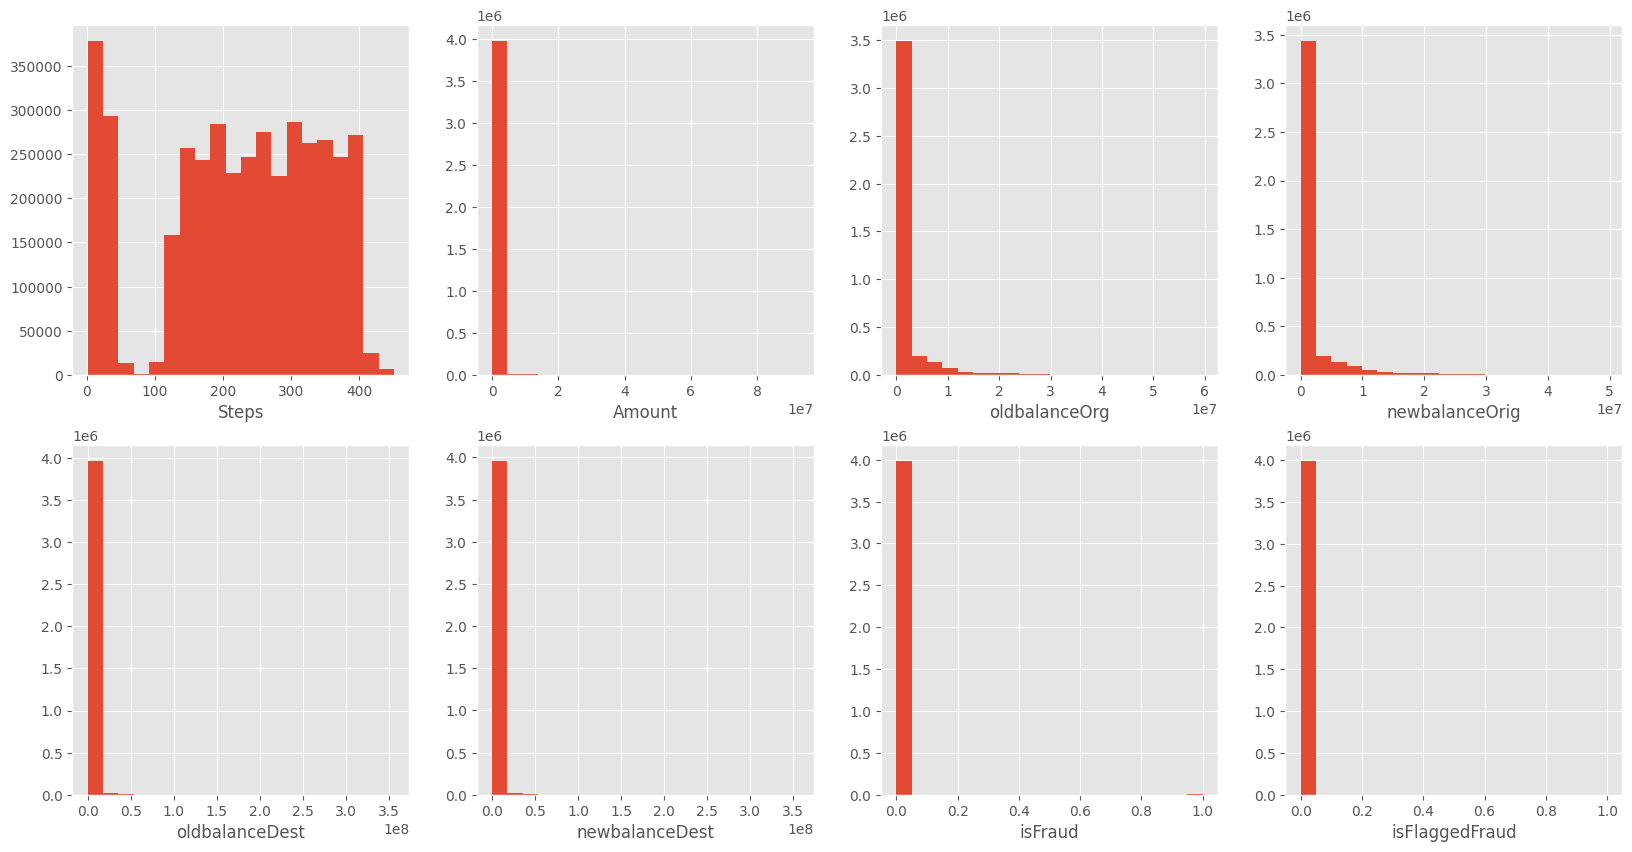

In [76]:
# Distribution
plt.figure(figsize=(20,10))

plt.subplot(2, 4, 1)
plt.hist(not_m_customers['step'],bins=20)
plt.xlabel('Steps')

plt.subplot(2, 4, 2)
plt.hist(not_m_customers['amount'],bins=20)
plt.xlabel('Amount')

plt.subplot(2, 4, 3)
plt.hist(not_m_customers['oldbalanceOrg'],bins=20)
plt.xlabel('oldbalanceOrg')

plt.subplot(2, 4, 4)
plt.hist(not_m_customers['newbalanceOrig'],bins=20)
plt.xlabel('newbalanceOrig')

plt.subplot(2, 4, 5)
plt.hist(not_m_customers['oldbalanceDest'],bins=20)
plt.xlabel('oldbalanceDest')

plt.subplot(2, 4, 6)
plt.hist(not_m_customers['newbalanceDest'],bins=20)
plt.xlabel('newbalanceDest')

plt.subplot(2, 4, 7)
plt.hist(not_m_customers['isFraud'],bins=20)
plt.xlabel('isFraud')

plt.subplot(2, 4, 8)
plt.hist(not_m_customers['isFlaggedFraud'],bins=20)
plt.xlabel('isFlaggedFraud')

plt.show()

Text(0, 0.5, 'Frequency')

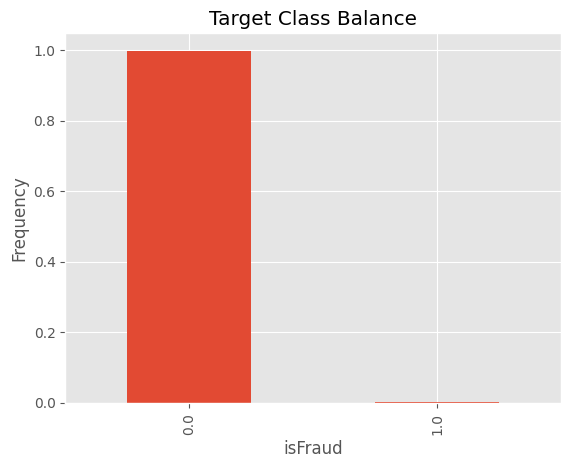

In [77]:
# Class Balance
not_m_customers['isFraud'].value_counts(normalize=True).plot(kind='bar');
plt.title('Target Class Balance')
plt.ylabel('Frequency')

Text(0.5, 0, 'newbalanceDest')

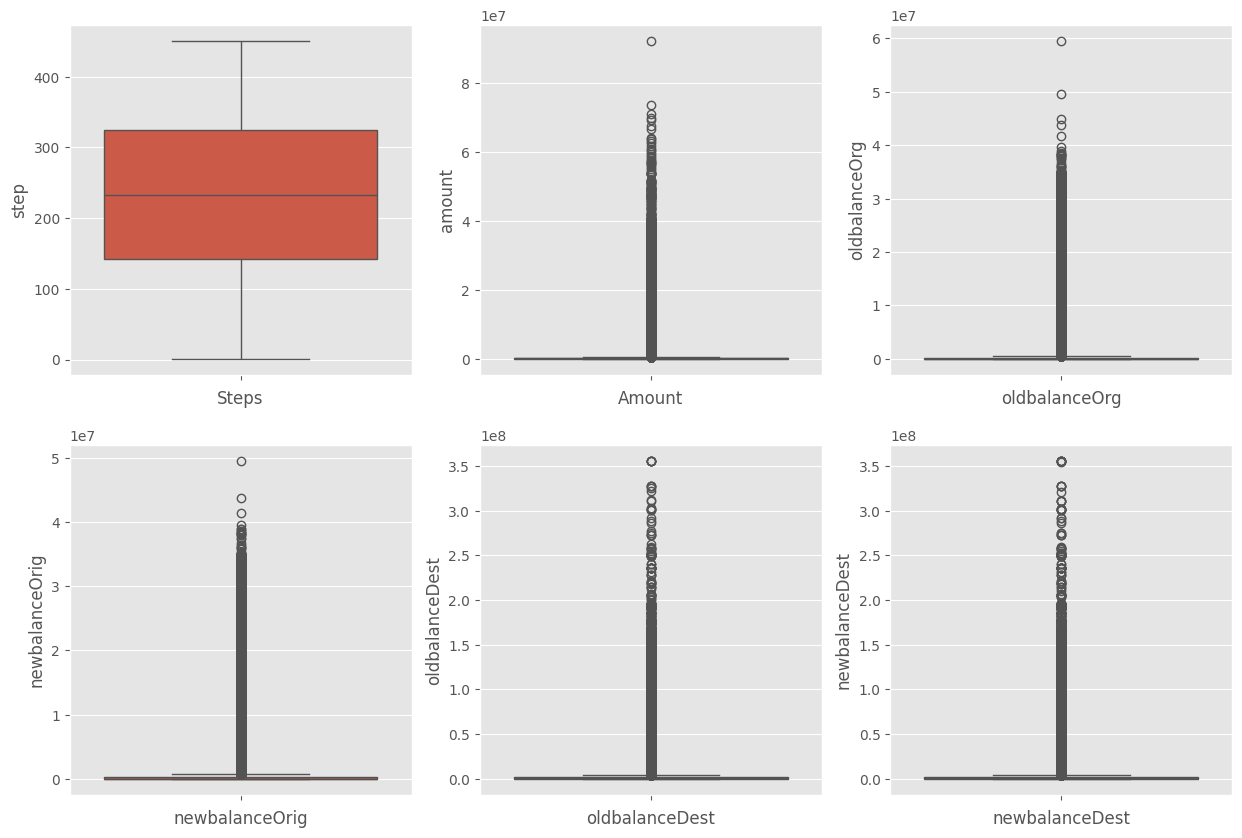

In [78]:
# Distribution
plt.figure(figsize=(15,10))

plt.subplot(2, 3, 1)
sns.boxplot(not_m_customers['step'])
plt.xlabel('Steps')

plt.subplot(2, 3, 2)
sns.boxplot(not_m_customers['amount'])
plt.xlabel('Amount')

plt.subplot(2, 3, 3)
sns.boxplot(not_m_customers['oldbalanceOrg'])
plt.xlabel('oldbalanceOrg')

plt.subplot(2, 3, 4)
sns.boxplot(not_m_customers['newbalanceOrig'])
plt.xlabel('newbalanceOrig')

plt.subplot(2, 3, 5)
sns.boxplot(not_m_customers['oldbalanceDest'])
plt.xlabel('oldbalanceDest')

plt.subplot(2, 3, 6)
sns.boxplot(not_m_customers['newbalanceDest'])
plt.xlabel('newbalanceDest')


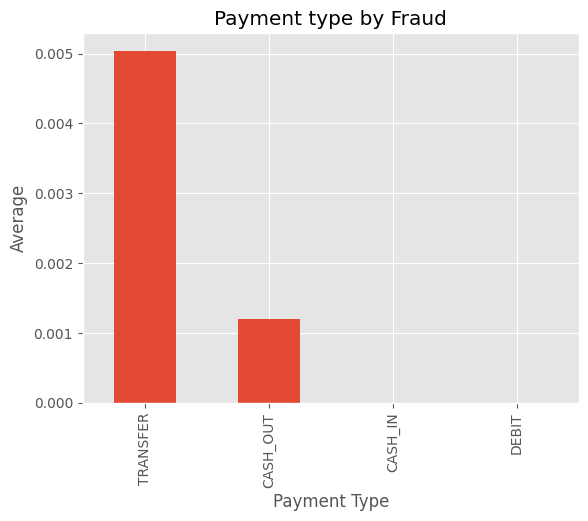

In [79]:
not_m_customers.groupby('type')['isFraud'].mean().sort_values(ascending=False).plot(
    kind='bar',
    title= 'Payment type by Fraud',
    xlabel= 'Payment Type',
    ylabel= 'Average'
)
plt.show()

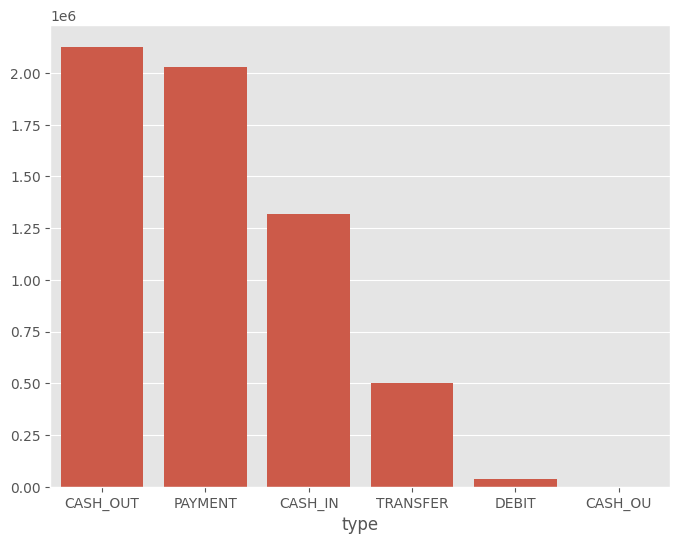

In [80]:
# Payment type count
type_count = data['type'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=type_count.index, y=type_count.values)
plt.show()

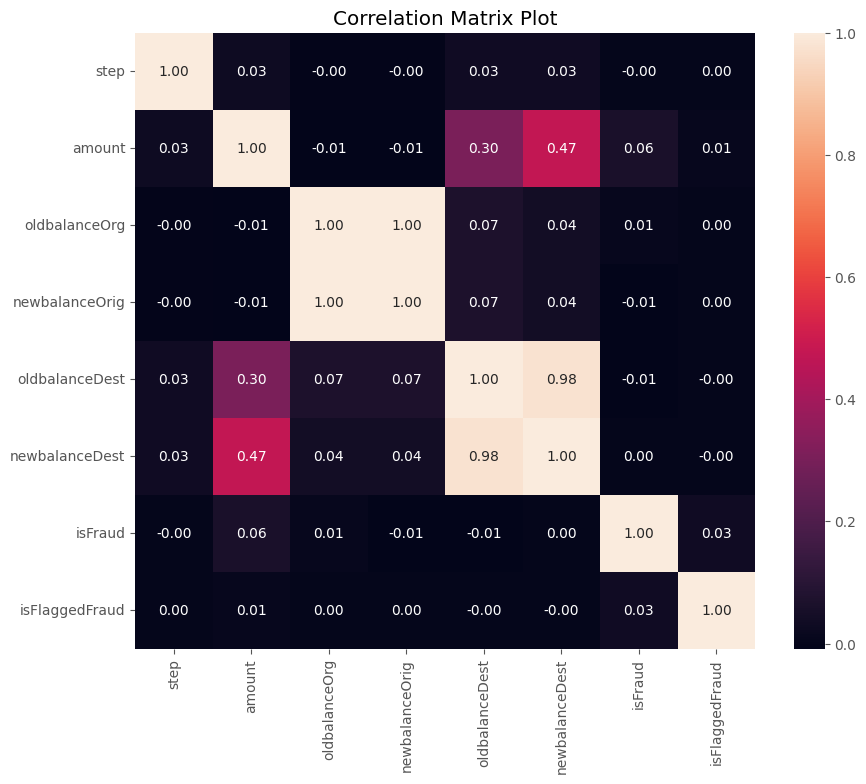

In [81]:
# Calculate the correlation of the numerical features
corr = data.select_dtypes('number').corr()

# Visualize
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.title('Correlation Matrix Plot')
plt.show()

# **Data Cleaning**

In [82]:
# Make a copy of the not_m_customers
cleaned_df = not_m_customers.copy()

In [83]:
# Drop High Cardinality Feature
cleaned_df.drop(columns=['step','nameOrig', 'nameDest', 'isFlaggedFraud'], inplace=True)

In [84]:
cleaned_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,TRANSFER,181.00,181.0,0.00,0.0,0.00,1.0
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.00,1.0
9,DEBIT,5337.77,41720.0,36382.23,41898.0,40348.79,0.0
10,DEBIT,9644.94,4465.0,0.00,10845.0,157982.12,0.0
15,CASH_OUT,229133.94,15325.0,0.00,5083.0,51513.44,0.0


In [85]:
# convert the data type
cleaned_df['isFraud'] = cleaned_df['isFraud'].astype(int)
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3985167 entries, 2 to 6015153
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   type            object 
 1   amount          float64
 2   oldbalanceOrg   float64
 3   newbalanceOrig  float64
 4   oldbalanceDest  float64
 5   newbalanceDest  float64
 6   isFraud         int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 243.2+ MB


# **Preprocessing**

In [86]:
X = cleaned_df.drop(columns='isFraud', axis=1)
y = cleaned_df.isFraud

In [87]:
# features to scale
Numerical = X.select_dtypes('number')
# Scale the data
scaler = StandardScaler()
scaled = scaler.fit_transform(Numerical)
# Convert to Dataframe
scaled_df = pd.DataFrame(scaled, columns= scaler.get_feature_names_out(), index=X.index)
print(scaled_df.shape)
scaled_df.head()

(3985167, 5)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
2,-0.360238,-0.350884,-0.357025,-0.412727,-0.424371
3,-0.360238,-0.350884,-0.357025,-0.407445,-0.424371
9,-0.353234,-0.339119,-0.346838,-0.402279,-0.415092
10,-0.347384,-0.349671,-0.357025,-0.410022,-0.388041
15,-0.049280,-0.346595,-0.357025,-0.411459,-0.412525


In [88]:
categories = X.select_dtypes('O')

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = encoder.fit_transform(categories).astype('int')
encoded_df = pd.DataFrame(encoded_data, columns= encoder.get_feature_names_out(), index=X.index)

print(encoded_df.shape)
encoded_df.head()

(3985167, 3)


,type_CASH_OUT,type_DEBIT,type_TRANSFER
2,0,0,1
3,1,0,0
9,0,1,0
10,0,1,0
15,1,0,0


In [89]:
# Concat the dataframes
X_transformed = pd.concat([scaled_df, encoded_df], axis=1)
print(X_transformed.shape)
X_transformed.head()

(3985167, 8)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_TRANSFER
2,-0.360238,-0.350884,-0.357025,-0.412727,-0.424371,0,0,1
3,-0.360238,-0.350884,-0.357025,-0.407445,-0.424371,1,0,0
9,-0.353234,-0.339119,-0.346838,-0.402279,-0.415092,0,1,0
10,-0.347384,-0.349671,-0.357025,-0.410022,-0.388041,0,1,0
15,-0.049280,-0.346595,-0.357025,-0.411459,-0.412525,1,0,0


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2789616, 8), (2789616,), (1195551, 8), (1195551,))

In [91]:
# Resample training Data

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original class distribution:\n", y_train.value_counts())
print("\nResampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

print(f'\nNew Shape: \n{X_train_resampled.shape}')
X_train_resampled.head()

Original class distribution:
 isFraud
0    2786097
1       3519
Name: count, dtype: int64

Resampled class distribution:
 isFraud
0    2786097
1    2786097
Name: count, dtype: int64

New Shape: 
(5572194, 8)


,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_OUT,type_DEBIT,type_TRANSFER
0,1.367081,-0.350936,-0.357025,0.244246,0.519044,0,0,1
1,-0.174555,-0.350936,-0.357025,-0.235393,-0.229362,0,0,1
2,-0.030491,-0.350748,-0.288810,-0.001905,-0.101406,0,0,0
3,-0.253624,1.869022,1.859421,-0.352235,-0.386681,0,0,0
4,-0.114508,-0.342972,-0.298444,-0.371913,-0.424371,0,0,0


## **Model Building**

In [92]:
model = DecisionTreeClassifier(random_state=42)# Instantiate Model
model.fit(X_train_resampled, y_train_resampled)# Fit model 

DecisionTreeClassifier(random_state=42)

In [93]:
# Make Predictions
ypred = model.predict(X_test)

## **Evaluation**

In [94]:
class_report = classification_report(y_test, ypred)
print(class_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1194013
           1       0.52      0.96      0.67      1538

    accuracy                           1.00   1195551
   macro avg       0.76      0.98      0.84   1195551
weighted avg       1.00      1.00      1.00   1195551



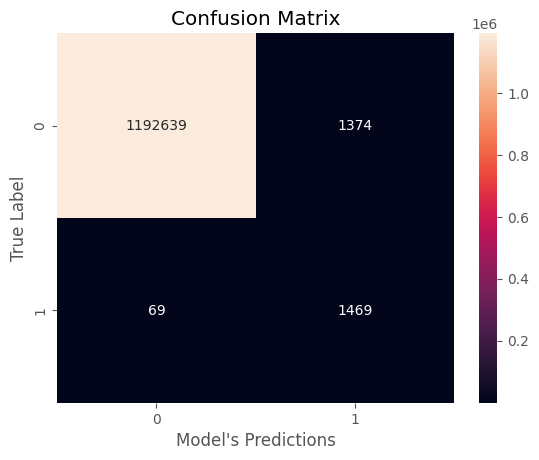

In [95]:
conf_matrix = confusion_matrix(y_test, ypred)

sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Model\'s Predictions')
plt.ylabel('True Label');

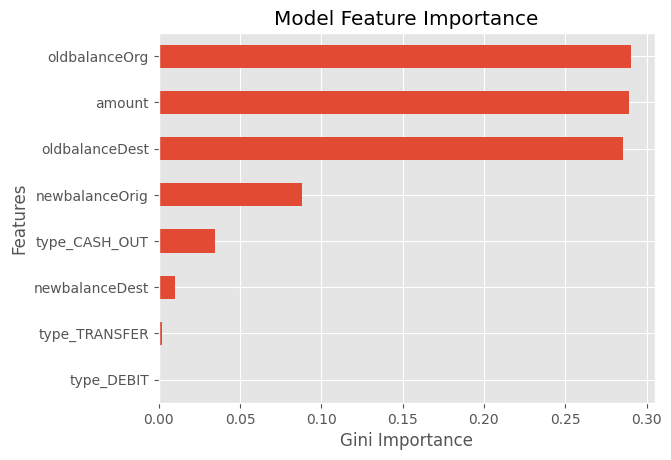

In [96]:
# Get Feature Importance
importances= model.feature_importances_

feat_imp = pd.Series(importances, index=X_transformed.columns).sort_values(ascending=True).plot(kind= 'barh',
                                                                                                title= 'Model Feature Importance',
                                                                                                xlabel= 'Gini Importance',
                                                                                                ylabel= 'Features')

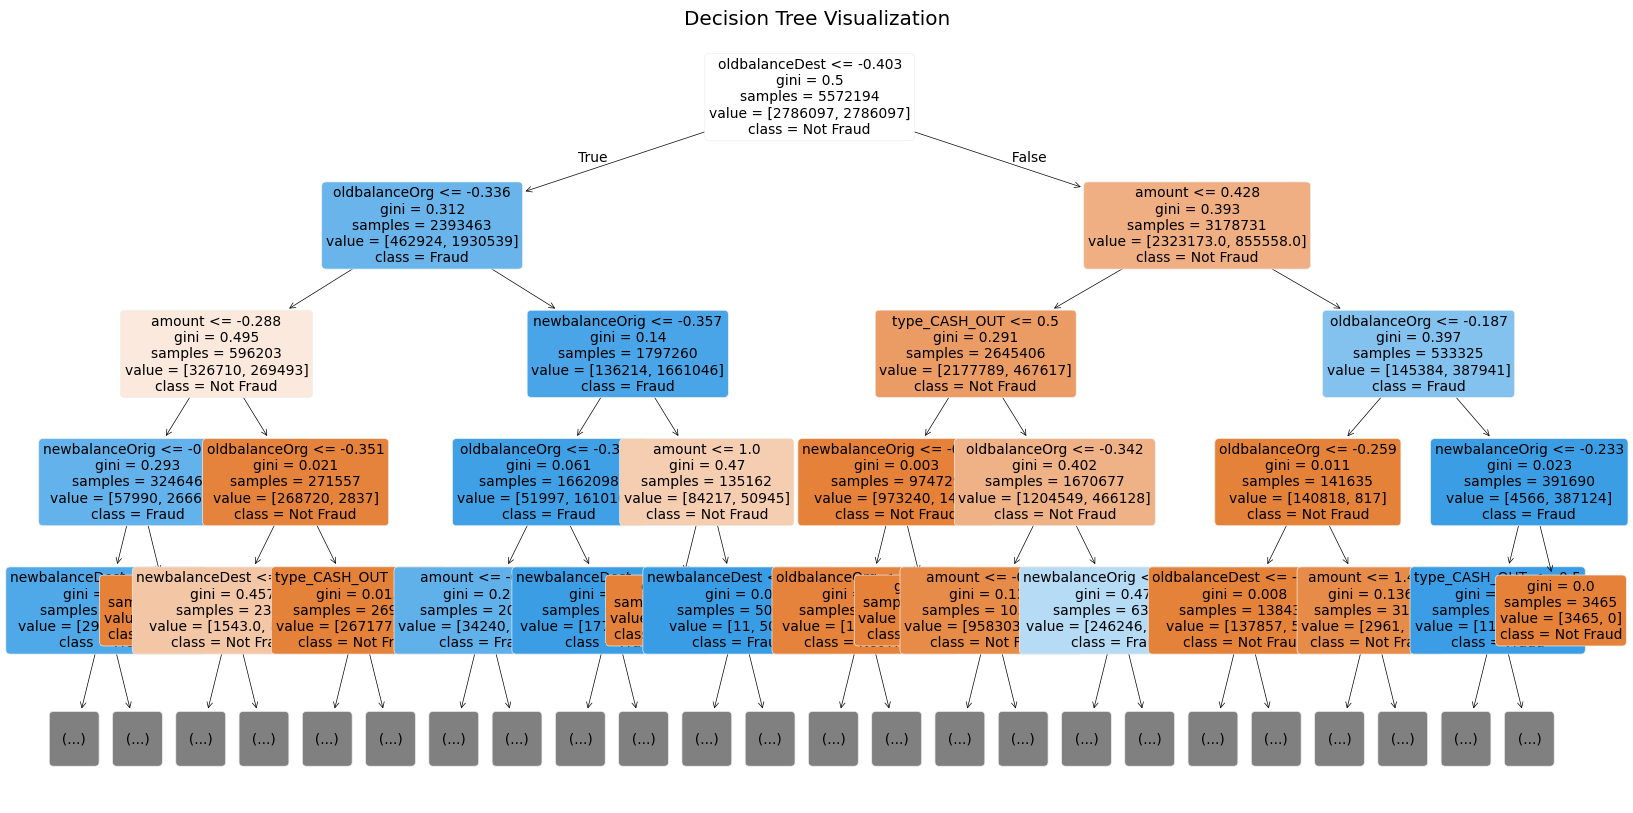

In [97]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X_transformed.columns, 
          class_names=['Not Fraud', 'Fraud'], 
          max_depth= 4, filled=True, 
          rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()